# Boundary-value problems

## 1. Linear problems

### Finite differences for Poiseuille flow

In this section, we solve the boundary value problem for Poiseuille flow:

$$
0 = P_l + \mu \, u_{yy}, \quad 0 <  y< h,
$$

with the Dirichlet boundary conditions $u(0)=u(h)=0$.

The steps are as follows:

1. **Discretization:**  
   We discretize the domain $y \in [0,h]$ using a grid with spacing $\Delta y$.

2. **Finite Difference Approximation:**  
   The second derivative is approximated using the central difference scheme:
   $$
   u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2},
   $$
   which is valid for the interior nodes (i.e., those excluding the boundaries). Boundary conditions need to be handled separately (see below).

4. **Matrix Formulation:**  
   With the finite difference approximation, the differential equation is rewritten in matrix form. Each interior row of the matrix represents the discretized version of the second derivative.

5. **Incorporating Boundary Conditions:**  
   The boundary conditions are imposed by replacing the rows corresponding to $y=0$ and $y=h$ with the conditions $u(0)=0$ and $u(h)=0$.

6. **Example Problem:**  
   For Poiseuille flow, the equation becomes
   $$
   \mu \, u_{yy} = -P_l,
   $$
   with the analytical solution given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python snippet below sets up the finite difference matrix, applies the boundary conditions via row replacement, and then solves the resulting linear system.


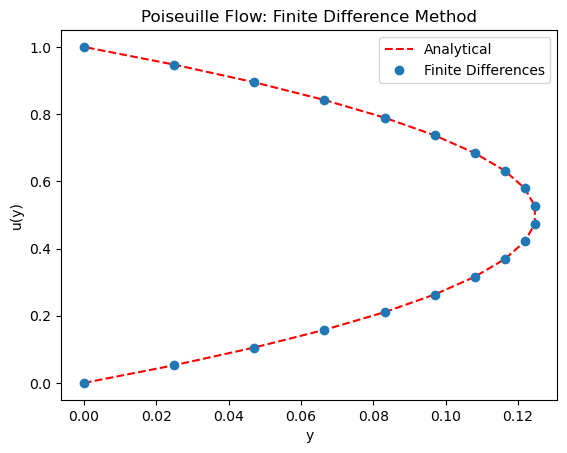

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 20          # Number of grid points
h_val = 1.0      # Domain [0, h]
mu = 1.0         # Viscosity coefficient
Pl = 1.0         # Pressure gradient

# Domain discretization
y = np.linspace(0, h_val, N)
dy = y[1] - y[0]

# Construct the finite difference matrix for u'' using central differences
A = np.zeros((N, N))
for i in range(1, N-1):
    A[i, i-1] = 1 / dy**2
    A[i, i]   = -2 / dy**2
    A[i, i+1] = 1 / dy**2

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0
A[0, :] = 0
A[0, 0] = 1.0
A[-1, :] = 0
A[-1, -1] = 1.0

# Set up the right-hand side vector.
# For interior nodes, the equation is: u'' = -Pl/mu.
b = np.full(N, -Pl/mu)
# Enforce boundary conditions in the right-hand side
b[0] = 0
b[-1] = 0

# Solve the linear system A u = b
u_numerical = np.linalg.solve(A, b)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Finite Differences')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Finite Difference Method')
plt.legend()
plt.show()


#### Structure of the Finite-Difference System (After Applying Boundary Conditions)

The discretized system for the Poiseuille flow problem is given by

$$
A\mathbf{u} = \mathbf{f},
$$

where the unknown vector is

$$
\mathbf{u} = \begin{pmatrix} u_0 \\ u_1 \\ \vdots \\ u_{N-1} \\ u_N \end{pmatrix}.
$$

The matrix \( A \) has the following structure after enforcing the Dirichlet boundary conditions:

$$
A = \begin{pmatrix}
1 & 0 & \cdots & 0 \\
\frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
0 & \cdots & \frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} \\
0 & \cdots & 0 & 0 & 1
\end{pmatrix}.
$$

The interior rows use the central difference approximation for the second derivative:

$$
u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2}, \quad i=1,2,\dots,N-1.
$$

Finally, the right-hand side vector $\mathbf{f}$ is initially defined for the interior nodes as

$$
f_i = -\frac{P_l}{\mu} \quad \text{for } i=1,2,\dots,N-1.
$$

To enforce the Dirichlet boundary conditions $ u_0 = 0$ and $ u_N = 0$, we must also **modify** (or "crush") the first and last elements of $ \mathbf{f} $ by setting:

$$
f_0 = 0 \quad \text{and} \quad f_N = 0.
$$

This ensures that both the system matrix $ A $ and the right-hand side vector $ \mathbf{f} $ correctly reflect the prescribed boundary conditions.


### Spectral Collocation using Chebyshev Polynomials for Poiseuille flow

In this section, we solve the same Poiseuille flow problem using spectral collocation with Chebyshev polynomials. The boundary value problem is

$$
0 = P_l + \mu \, u_{yy}, \quad u(0)=u(h)=0.
$$

The key ideas are:

1. **Chebyshev Collocation Points:**  
   We use Chebyshev–Gauss–Lobatto points, which are defined on the interval $[-1,1]$. They are given by
   $$
   x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0,\ldots, N,
   $$
   and then mapped to the domain $y\in [0, h]$ via
   $$
   y = \frac{(x+1)h}{2}.
   $$

2. **Differentiation Matrix:**  
   A Chebyshev differentiation matrix $D$ is computed, and then scaled to account for the transformation from $[-1,1]$ to $[0,h]$. The second derivative matrix is obtained as:
   $$
   D_2 = \left(\frac{2}{h}\right)^2 D^2.
   $$

3. **Imposing Boundary Conditions:**  
   The rows corresponding to the endpoints (i.e., the degrees of freedom at the boundaries) are replaced to enforce the Dirichlet conditions $u(0)=0$ and $u(h)=0$.

4. **Solving the System:**  
   With the modified differentiation matrix and right-hand side $f = -P_l/\mu$ (from $u_{yy} = -P_l/\mu$), we solve the system to obtain the numerical solution. The analytical solution is again given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python code below implements these steps.


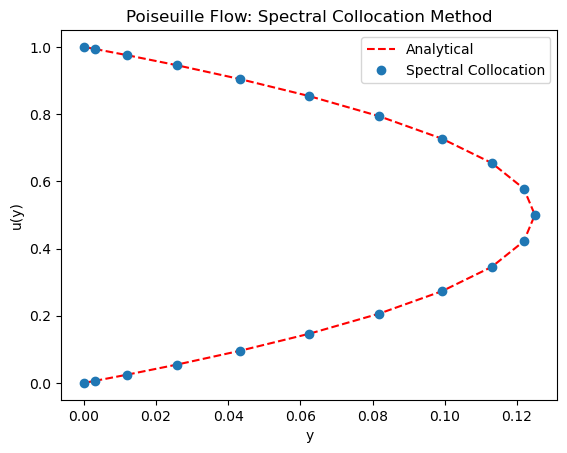

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def cheb(N):
    """
    Compute the Chebyshev differentiation matrix and nodes.
    
    Returns:
        D (ndarray): Chebyshev differentiation matrix (size (N+1) x (N+1)).
        x (ndarray): Chebyshev nodes in [-1, 1].
    """
    if N == 0:
        return np.array([[0]]), np.array([1.0])
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * ((-1) ** np.arange(N + 1))
    X = np.tile(x, (N + 1, 1))
    dX = X - X.T
    D = (np.outer(c, 1/c)) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))
    return D, x

# Parameters for the problem
N = 20         # Degree of the Chebyshev polynomial (number of collocation points minus one)
h_val = 1.0    # Domain: [0, h]
mu = 1.0       # Viscosity coefficient
Pl = 1.0       # Pressure gradient

# Compute Chebyshev differentiation matrix and nodes
D, x_cheb = cheb(N)

# Transform Chebyshev nodes from [-1, 1] to [0, h]
y = (x_cheb + 1) * h_val / 2

# Scale the differentiation matrix for the transformation:
# Since y = (x+1)*h/2, we have dy/dx = h/2 so that d/dy = (2/h)*d/dx.
D = 2/h_val * D
D2 = np.dot(D, D)  # Second derivative matrix

# Right-hand side of the differential equation: u'' = -Pl/mu
f = -Pl/mu * np.ones(N + 1)

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0 by replacing the boundary rows.
D2[0, :] = 0
D2[0, 0] = 1.0
D2[-1, :] = 0
D2[-1, -1] = 1.0
f[0] = 0
f[-1] = 0

# Solve the system: mu * u'' = -Pl  ==>  u'' = -Pl/mu
u_numerical = np.linalg.solve(mu * D2, f)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Spectral Collocation')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Spectral Collocation Method')
plt.legend()
plt.show()


#### Comparison of Sparsity Patterns

When setting up the linear systems prior to solving, the two methods lead to very different matrix structures:

- **Finite Differences:**  
  The finite-difference method discretizes the second derivative using central differences. This produces a **sparse** matrix where nonzero elements are mostly confined to the main diagonal and the first sub- and super-diagonals (i.e., a tridiagonal pattern). The only exceptions occur in the rows modified to enforce Dirichlet boundary conditions.

- **Spectral Collocation (Chebyshev):**  
  In contrast, the spectral collocation method using Chebyshev polynomials results in a **dense** differentiation matrix. The global nature of Chebyshev polynomials causes nearly every element of the second derivative matrix to be nonzero—even after modifying the boundary rows to impose the Dirichlet conditions.

This difference means that finite-difference systems are usually cheaper to store and solve due to their sparsity, while spectral methods, although yielding dense matrices, can offer higher accuracy for smooth problems.


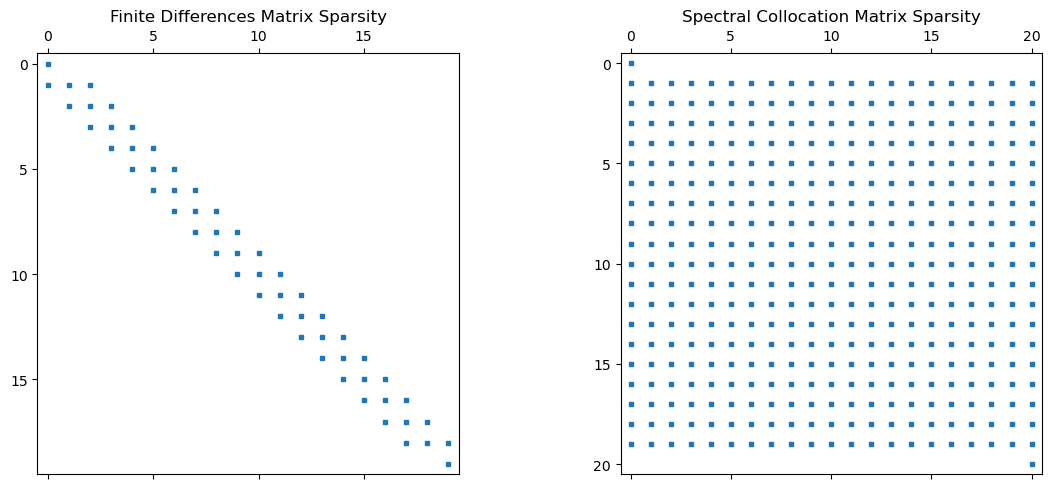

In [19]:
# Plot the sparsity patterns
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.spy(A, markersize=3)
plt.title('Finite Differences Matrix Sparsity')

plt.subplot(1,2,2)
plt.spy(D2, markersize=3)
plt.title('Spectral Collocation Matrix Sparsity')

plt.tight_layout()
plt.show()

Note how the first and last rows are modified so they effectively enforce the Dirichlet boundary conditions $u(0) = u(h) = 0$.